In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Lambda, Concatenate, Multiply, Reshape, ActivityRegularization
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
import keras.backend as K

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from awkde import GaussianKDE

In [51]:
# Data
data_dir = '../data'

X_train = np.load(data_dir + '/unweighted_events/X_train_point_by_point_9.npy')
y_train = np.load(data_dir + '/unweighted_events/y_train_point_by_point_9.npy')
r_train = np.load(data_dir + '/unweighted_events/r_train_point_by_point_9.npy')

X_calibration = np.load(data_dir + '/unweighted_events/X_calibration.npy')
weights_calibration = np.load(
    data_dir + '/unweighted_events/weights_calibration.npy')
    
# Scale data
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype=np.float64))
X_train_transformed = scaler.transform(X_train)
X_calibration_transformed = scaler.transform(X_calibration)

log_r_gradients_train = np.zeros((r_train.shape[0], 43))
log_r_gradients_train[:,0] = np.log(r_train)

In [4]:
theta1 = 708
theta = 9

# Covariance matrix in X space

In [ ]:
X_indices = [0,1,2,3,39,40,41] # j1 momentum + delta eta, delta phi, mjj
cov_X = np.cov(X_train_transformed[::10,X_indices])
print(cov_X)

# Regressor

In [62]:
n_features = 42

def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x

    return f

def hidden_layers(n,
                  hidden_layer_size=100,
                  activation='tanh',
                  dropout_prob=0.0):
    r = []
    for k in range(n):
        if dropout_prob > 0.:
            s = stack_layer([
                Dropout(dropout_prob),
                Dense(hidden_layer_size, activation=activation)
            ])
        else:
            s = stack_layer([Dense(hidden_layer_size, activation=activation)])
        r.append(s)
    return stack_layer(r)

def loss_function_regression(y_true, y_pred):
    return losses.mean_squared_error(y_true[:,0], y_pred[:,0])

def make_regressor(n_hidden_layers=3,
                   hidden_layer_size=100,
                   activation='tanh',
                   dropout_prob=0.0):

    # Inputs
    input_layer = Input(shape=(n_features,))

    # Network
    hidden_layer = Dense(hidden_layer_size, activation=activation)(input_layer)
    if n_hidden_layers > 1:
        hidden_layer_ = hidden_layers(n_hidden_layers - 1,
                                      hidden_layer_size=hidden_layer_size,
                                      activation=activation,
                                      dropout_prob=dropout_prob)
        hidden_layer = hidden_layer_(hidden_layer)
    log_r_hat_layer = Dense(1, activation='linear')(hidden_layer)
    s_hat_layer = Lambda(lambda x : 1. / 1. + x)(log_r_hat_layer)

    # gradients with respect to x
    gradient_layer = Lambda(lambda x: K.gradients(x[0], x[1])[0],
                            output_shape=(n_features,))([s_hat_layer, input_layer])

    # Combine outputs
    output_layer = Concatenate()([log_r_hat_layer, gradient_layer])
    model = Model(inputs=[input_layer], outputs=[output_layer])

    # Compile model
    model.compile(loss=loss_function_regression,
                  optimizer=optimizers.Adam(clipnorm=1.))

    return model

In [63]:
# Train score regression
regr = KerasRegressor(lambda: make_regressor(n_hidden_layers=2),
                     epochs=20, verbose=2, validation_split=0.2,
                     callbacks=[EarlyStopping(verbose=1, patience=3)])

regr.fit(X_train_transformed, log_r_gradients_train)

Train on 80000 samples, validate on 20000 samples
Epoch 1/20
 - 4s - loss: 0.1519 - val_loss: 0.1775
Epoch 2/20
 - 3s - loss: 0.0654 - val_loss: 0.1209
Epoch 3/20
 - 3s - loss: 0.0469 - val_loss: 0.0971
Epoch 4/20
 - 3s - loss: 0.0357 - val_loss: 0.0759
Epoch 5/20
 - 3s - loss: 0.0289 - val_loss: 0.0700
Epoch 6/20
 - 3s - loss: 0.0246 - val_loss: 0.0638
Epoch 7/20
 - 3s - loss: 0.0219 - val_loss: 0.0623
Epoch 8/20
 - 4s - loss: 0.0200 - val_loss: 0.0485
Epoch 9/20
 - 4s - loss: 0.0182 - val_loss: 0.0490
Epoch 10/20
 - 3s - loss: 0.0166 - val_loss: 0.0601
Epoch 11/20
 - 3s - loss: 0.0158 - val_loss: 0.0421
Epoch 12/20
 - 3s - loss: 0.0148 - val_loss: 0.0489
Epoch 13/20
 - 3s - loss: 0.0143 - val_loss: 0.0400
Epoch 14/20
 - 3s - loss: 0.0136 - val_loss: 0.0427
Epoch 15/20
 - 4s - loss: 0.0126 - val_loss: 0.0447
Epoch 16/20
 - 3s - loss: 0.0124 - val_loss: 0.0364
Epoch 17/20
 - 4s - loss: 0.0125 - val_loss: 0.0340
Epoch 18/20
 - 4s - loss: 0.0110 - val_loss: 0.0480
Epoch 19/20
 - 5s - los

In [67]:
calibration_predictions = regr.predict(X_calibration_transformed)
log_r_hat_calibration = calibration_predictions[:,0]
s_hat_calibration = 1. / (1. + np.exp(log_r_hat_calibration))
gradients_calibration = calibration_predictions[:,1:]

In [ ]:
grad_cov_grad = np.dot(gradients_calibration[:,X_indices], np.dot(cov_X, gradients_calibration[:,X_indices])

In [ ]:
print(grad_cov_grad)

# Calibration

In [69]:
pdf_nom = GaussianKDE(alpha=0.5)
pdf_nom.fit(s_hat_calibration.reshape((-1,1)), weights=weights_calibration[theta,::])

pdf_den = GaussianKDE(alpha=0.5)
pdf_den.fit(s_hat_calibration.reshape((-1,1)), weights=weights_calibration[theta1,::])

(array([0.53772868]), array([[0.02642862]]))

In [71]:
pdf_nom_fix = GaussianKDE(alpha=None)
pdf_nom_fix.fit(s_hat_calibration.reshape((-1,1)), weights=weights_calibration[theta,::])

pdf_den_fix = GaussianKDE(alpha=None)
pdf_den_fix.fit(s_hat_calibration.reshape((-1,1)), weights=weights_calibration[theta1,::])

(array([0.53772868]), array([[0.02642862]]))

In [72]:
si = np.linspace(0., 1., 200).reshape((-1,1))

p_nom_eval = pdf_nom.predict(si)
p_den_eval = pdf_den.predict(si)
p_nom_fix_eval = pdf_nom_fix.predict(si)
p_den_fix_eval = pdf_den_fix.predict(si)

ratio_eval = p_nom_eval / p_den_eval
ratio_fix_eval = p_nom_fix_eval / p_den_fix_eval

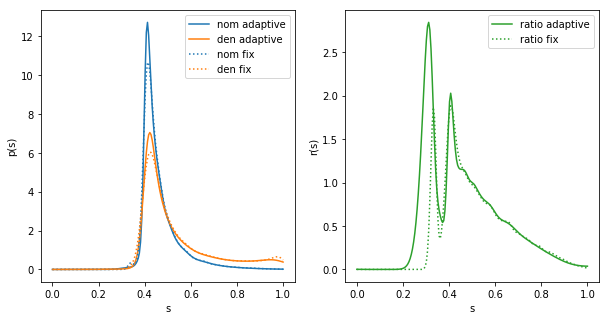

In [73]:
plt.figure(figsize=(10.,5.))

plt.subplot(1,2,1)
plt.plot(si,p_nom_eval, c='C0', label='nom adaptive')
plt.plot(si,p_den_eval, c='C1', label='den adaptive')
plt.plot(si,p_nom_fix_eval, c='C0', ls=':', label='nom fix')
plt.plot(si,p_den_fix_eval, c='C1', ls=':', label='den fix')
plt.xlabel('s')
plt.ylabel('p(s)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(si,ratio_eval, c='C2', label='ratio adaptive')
plt.plot(si,ratio_fix_eval, c='C2', ls=':', label='ratio fix')
plt.xlabel('s')
plt.ylabel('r(s)')
plt.legend()

plt.show()